In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import pydot
from IPython.display import Image, display

In [2]:
class Node(object):
    def __init__(self):
        self.value = None              # feature name for binary split the current node / class label at leaf node
        self.pathCondition = None      # threshold/combination for binary split
        
        self.leftChild = None          # tree path if condition is met
        self.rightChild = None         # tree path if condition is not met
        
        self.gini_impurity = None      # gini_impurity of the node
        self.samples = None            # number of samples in node

In [3]:
def getGiniImpurityOfNode(target_column):
    
    gini = 0
    
    classes = pd.unique(target_column)
    
    # Total number of samples in target column T
    msamples = target_column.shape[0]
    
    for c in classes:
        # Total occurences of class c in T
        mc = target_column[ target_column == c ].shape[0]
        
        probability_c = mc/ msamples
        
        gini += probability_c ** 2

        if probability_c == 1:
            return 0, c
        
    gini_impurity = 1 - gini
    
    return gini_impurity, -1

In [4]:
def get_all_binary_splits_categorical(values):
    
    def divide_into_groups(values, group1=[], group2=[], index=0):
        if index == len(values):
            if len(group1)!=0 and len(group2)!=0:
                g1 = str(np.sort(group1))
                g2 = str(np.sort(group2))

                if g1 not in already_made.keys() and g2 not in already_made.keys():

                    group1s.append(group1)
                    group2s.append(group2)

                    already_made[g1] = 0
                    already_made[g2] = 0

            return

        # Include the current value in group 1
        divide_into_groups(values, group1 + [values[index]], group2, index + 1)

        # Include the current value in group 2
        divide_into_groups(values, group1, group2 + [values[index]], index + 1)  
    
    group1s=[]
    group2s=[]

    already_made = {}
    
    categories = pd.unique(values).tolist()
    
    divide_into_groups(categories)
    
    return group1s, group2s

In [5]:
def get_split_threshold_for_feature(df, f):
    
    lowestGiniImpurity_after = 2
    
    values = df[f].values
    values = np.sort(values)

    T = df.shape[0]

    for threshold in values:

        group1 = df[df[f] <= threshold]
        group2 = df[df[f] > threshold]

        if group1.shape[0] == 0 or group2.shape[0] == 0:
            break

        gini_impurity_group1, leaf_label1 = getGiniImpurityOfNode(group1[target])
        gini_impurity_group2, leaf_label2 = getGiniImpurityOfNode(group2[target])

        T1 = group1.shape[0]
        T2 = group2.shape[0]      

        gini_impurity_after = (T1/T)* gini_impurity_group1 + (T2/T)* gini_impurity_group2

        if gini_impurity_after < lowestGiniImpurity_after:
            lowestGiniImpurity_after = gini_impurity_after
            cthreshold = threshold

    return lowestGiniImpurity_after, [cthreshold]


In [6]:
def get_binary_split_for_feature(df, f):
    
    lowestGiniImpurity_after = 2
    g1 = None
    g2 = None
    
    T = df.shape[0]
    
    values = df[f].values
    group1s, group2s = get_all_binary_splits_categorical(values)
    
    for i in range(len(group1s)):
        
        group1_cols = group1s[i]
        group2_cols = group2s[i]
        
        group1 = df[ df[f].isin(group1_cols )]
        group2 = df[ df[f].isin(group2_cols )]
        
        gini_impurity_group1, leaf_label1 = getGiniImpurityOfNode(group1[target])
        gini_impurity_group2, leaf_label2 = getGiniImpurityOfNode(group2[target])

        T1 = group1.shape[0]
        T2 = group2.shape[0]      

        gini_impurity_after = (T1/T)* gini_impurity_group1 + (T2/T)* gini_impurity_group2

        if gini_impurity_after < lowestGiniImpurity_after:
            lowestGiniImpurity_after = gini_impurity_after
            g1 = group1_cols
            g2 = group2_cols

    return lowestGiniImpurity_after, [g1, g2]

In [7]:
def get_gini_gain(gini_impurity_before, gini_impurity_after):
    
    gini_gain = gini_impurity_before - gini_impurity_after
    
    return gini_gain

In [8]:
def findBestSplit(df, features):
    
    maxGain = 0
    final_decision = []
    F = -1
    
    gini_impurity_before, leaf_label = getGiniImpurityOfNode(df[target])
    
    if gini_impurity_before == 0:
        return maxGain, F, final_decision, leaf_label
    
    T = df.shape[0]
    
    for f in features:
        if is_numeric_dtype(df[f]):
            GiniImpurity_after, decision = get_split_threshold_for_feature(df, f)
        else:
            GiniImpurity_after, decision = get_binary_split_for_feature(df, f)

    
        gini_gain = get_gini_gain(gini_impurity_before, GiniImpurity_after)
        
        if gini_gain > maxGain:
                F = features.index(f)
                maxGain = gini_gain
                final_decision = decision
    
    return maxGain, F, final_decision, -1

In [9]:
def build_CART_classifier(df, features):
    
    maxGain, F, decision, leaf_label = findBestSplit(df, features)
    
    root = Node()

    if maxGain == 0:
        # in case the node is a leaf node then set the value of node as class label
        root.value = leaf_label
        root.samples = df.shape[0]
        root.gini_impurity = 0
        
        return root
    
    node_gini_impurity, _ = getGiniImpurityOfNode(df[target])
    root.gini_impurity = np.round(node_gini_impurity, 2)
    root.samples = df.shape[0]
    
    F = features[F]
    
    root.value = F
    root.pathCondition = decision
    
    if len(decision) == 1:
        cthreshold = decision[0]
        
        group1 = df[df[F] <= cthreshold]
        group2 = df[df[F] > cthreshold]
    else:
        group1_cols = decision[0]
        group2_cols = decision[1]
        
        group1 = df[ df[F].isin(group1_cols )]
        group2 = df[ df[F].isin(group2_cols )]
        
    
    
    subtree1 = build_CART_classifier(group1, features)
    subtree2 = build_CART_classifier(group2, features)
    
    root.leftChild = subtree1
    root.rightChild = subtree2

    return root

In [10]:
def tree_to_dot(tree):
    "Function to convert decision tree to dot format"

    node_style = {"shape":"", 'style':"filled", 'fillcolor':"coral"}    
    graph_style = {'bgcolor':""}
    edge_style = {'color': ""}
    
    tree_graph = pydot.Dot(graph_type="digraph", strict=True, rankdir="TB", **graph_style)
    
    nodes = {}

    def recursive_append(parent_name, current_node, edge_label):
        "Recursively iterate through the tree to export to dot by creating node and edges."
        
        _node_style = node_style.copy()
        _edge_style = edge_style.copy()
        
        if current_node.gini_impurity != 0: 
            if len(current_node.pathCondition) == 1:
                node_label = "Is {} <= {}?\n" +\
                "Gini Impurity = {} \n"+ \
                  "Samples = {}"

                node_label = node_label.format(current_node.value,current_node.pathCondition,
                                               current_node.gini_impurity, current_node.samples)
                    
            else:
                node_label = "Binary Split-> {}\n" +\
                        "Gini Impurity = {} \n"+ \
                          "Samples = {}"

                node_label = node_label.format(current_node.value,
                                               current_node.gini_impurity, current_node.samples)                
        else:
            node_label = "{} = {}".format(target, current_node.value)
            _node_style["shape"] = "diamond"

        if edge_label is not None:
            _edge_style['label'] = edge_label  

        if node_label in nodes.keys():
            nodes[node_label] = nodes[node_label] + 1 
        else:
            nodes[node_label] = 0

        node_name = node_label + str(nodes[node_label])

        if current_node.gini_impurity == 0:
            _node_style["fillcolor"]="chartreuse3"

        node = pydot.Node(name=node_name, label=node_label, **_node_style)
        tree_graph.add_node(node)

        if parent_name is not None:
            edge = pydot.Edge(parent_name, node_name, **_edge_style)
            tree_graph.add_edge(edge)
        

        if current_node.leftChild:
            if len(current_node.pathCondition) == 1:
                recursive_append(node_name, current_node.leftChild, 'True')
                recursive_append(node_name, current_node.rightChild, 'False')
            else:
                left_tree_cols = current_node.pathCondition[0]
                right_tree_cols = current_node.pathCondition[1]
                
                recursive_append(node_name, current_node.leftChild, str(left_tree_cols))
                recursive_append(node_name, current_node.rightChild, str(right_tree_cols))
                
    recursive_append(None, tree, None)

    return tree_graph

### Training:

In [11]:
df = pd.read_csv("../datasets/playtennis.csv")

features = ['outlook', 'temp', 'humidity', 'wind']
target = 'play'

In [12]:
# Train Decision tree
cart_tree = build_CART_classifier(df, features)

### Display Tree:

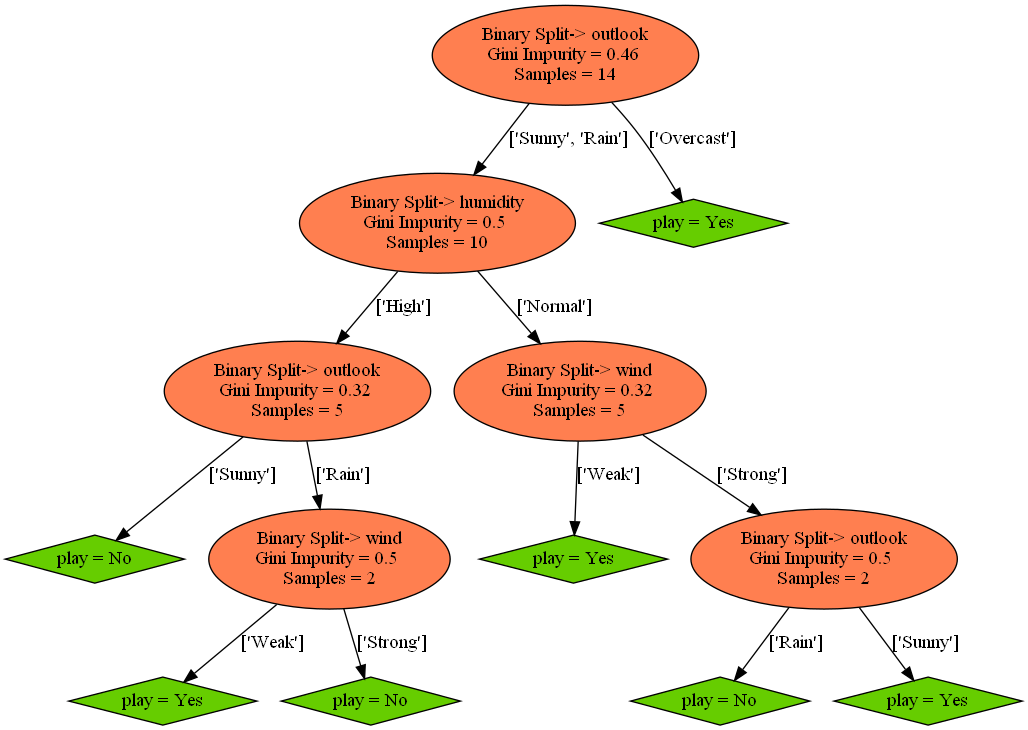

In [13]:
tree_graph = tree_to_dot(cart_tree)

tree_graph.write_png("../snapshots/cart_classification_comb_split.png")

# Display image directly without saving (requires IPython)
plt = Image(tree_graph.create_png())
display(plt)